<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#TextCNN" data-toc-modified-id="TextCNN-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>TextCNN</a></span><ul class="toc-item"><li><span><a href="#notes:" data-toc-modified-id="notes:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>notes:</a></span></li></ul></li><li><span><a href="#LSTM" data-toc-modified-id="LSTM-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>LSTM</a></span></li></ul></div>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#TextCNN" data-toc-modified-id="TextCNN-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>TextCNN</a></span><ul class="toc-item"><li><span><a href="#notes:" data-toc-modified-id="notes:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>notes:</a></span></li></ul></li><li><span><a href="#LSTM" data-toc-modified-id="LSTM-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>LSTM</a></span></li></ul></div>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/Text-Classification/code")
!pip install pyLDAvis
!pip install gensim
!pip install pandas==1.3.0
import nltk
nltk.download('punkt')
nltk.download('stopwords')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import numpy as np 
from sklearn import metrics
from clustering_utils import *
from eda_utils import *
from nn_utils_keras import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from data_utils import *

from classification_utils import *
####################################
### string normalized
####################################


from gensim.utils import tokenize
from nltk.tokenize import word_tokenize
from gensim.parsing.preprocessing import remove_stopwords

def normal_string(x):
    x = remove_stopwords(x)
#     x = " ".join(preprocess_string(x))
    x = " ".join(word_tokenize(x, preserve_line=False)).strip()
    return x


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [3]:
train, test = load_data()
train, upsampling_info = upsampling_train(train)

train_text, train_label = train_augmentation(train, select_comb=[['text'], ['reply', 'reference_one'], ['Subject', 'reference_one', 'reference_two']])
# train_text, train_label = train_augmentation(train, select_comb=None)
test_text, test_label = test['text'], test['label']

# test_text = test_text.apply(lambda x: normal_string(x))
# train_text = train_text.apply(lambda x: normal_string(x))


may use cols: 
 ['global_index', 'doc_path', 'label', 'reply', 'reference_one', 'reference_two', 'tag_reply', 'tag_reference_one', 'tag_reference_two', 'Subject', 'From', 'Lines', 'Organization', 'contained_emails', 'long_string', 'text', 'error_message']
combination 1 train:  ['text']
combination 2 train:  ['reply', 'reference_one']
combination 3 train:  ['Subject', 'reference_one', 'reference_two']


In [4]:
####################################
### label mapper
####################################
labels = sorted(train_label.unique())
label_mapper = dict(zip(labels, range(len(labels))))
train_label = train_label.map(label_mapper)
test_label = test_label.map(label_mapper)
y_train = train_label
y_test = test_label

print(train_text.shape)
print(test_text.shape)
print(train_label.shape)
print(test_label.shape)
print(labels)

(35439,)
(7761,)
(35439,)
(7761,)
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


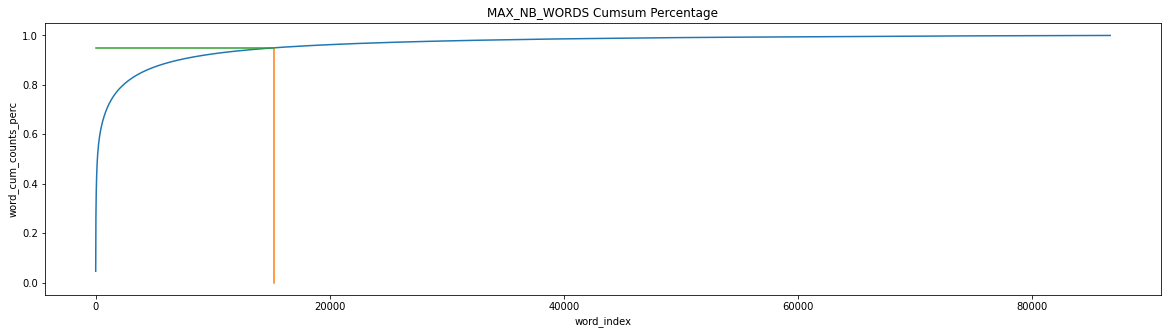

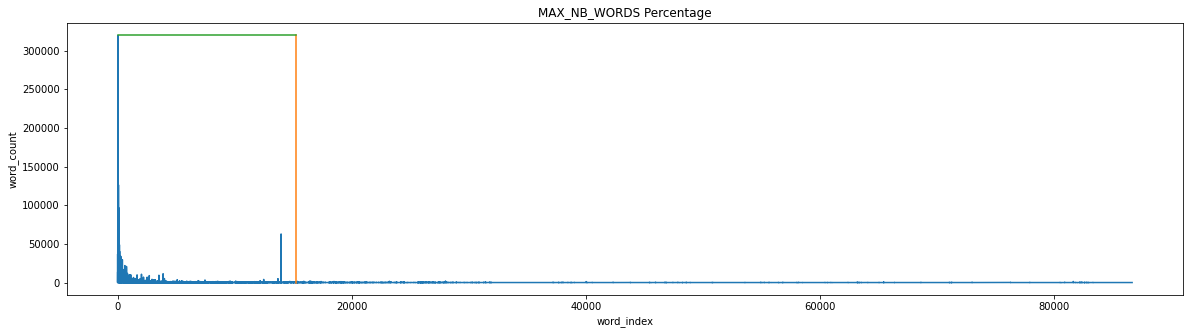

Cut index with 95.0 % of corpus:  15235 

    index  word   count
0      44   the  319692
1      33    to  162960
2      17    of  146543
3      56     a  142489
4      75   and  126318
5      49     i  116501
6      31    in  100411
7      84    is   97159
8     137  that   89106
9      83    it   74892
10  13970    ax   62840
11     53   for   61277
12     39   you   60898
13    156     s   48862
14    163     t   44558
15    139    on   44511
16     63  this   44491
17     86    be   42140
18     76   are   41860
19    165   not   40463
extreme frequent words:        word   count
17       of  146543
31       in  100411
33       to  162960
39      you   60898
44      the  319692
49        i  116501
53      for   61277
56        a  142489
75      and  126318
83       it   74892
84       is   97159
137    that   89106
13970    ax   62840


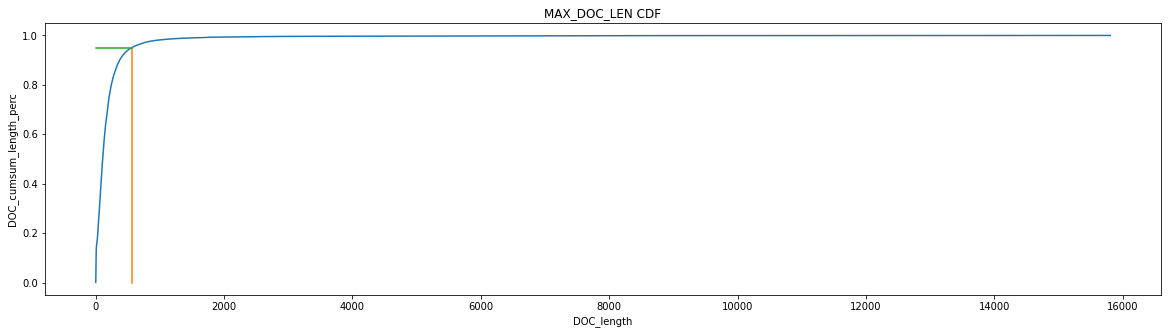

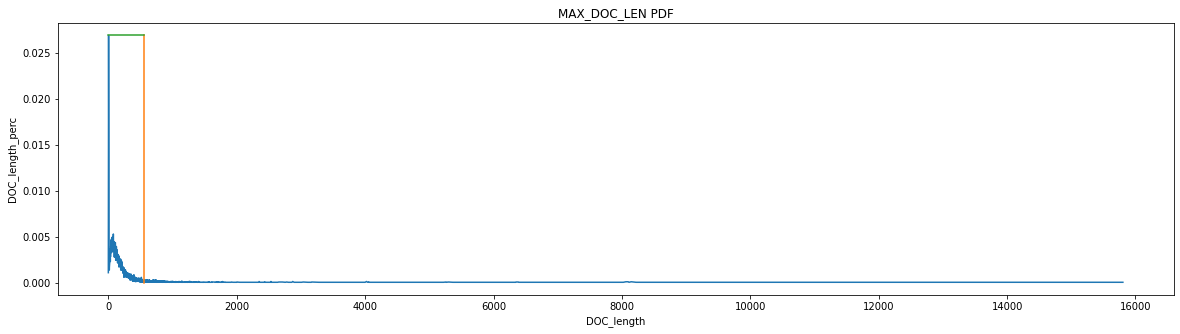

Cut index with 95.0 % of corpus:  560


In [5]:

####################################
### hyper params 
####################################
filters = '"#$%&()*+,-/:;<=>@[\\]^_`{|}~\t\n0123465789!.?\''
MAX_NB_WORDS_ratio = 0.95
MAX_DOC_LEN_ratio = 0.95
MAX_NB_WORDS = eda_MAX_NB_WORDS(train_text, ratio=MAX_NB_WORDS_ratio, char_level=False, filters=filters)
MAX_DOC_LEN = eda_MAX_DOC_LEN(train_text, ratio=MAX_DOC_LEN_ratio, char_level=False, filters=filters)

In [6]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, Dropout, Activation, Input, Flatten, Concatenate, Lambda
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow import keras
import numpy as np
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# TextCNN

## notes:

In [7]:
####################################
### train val test split
####################################
X_train_val, y_train_val, X_test, y_test = train_text, train_label, test_text, test_label
X_train, x_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val)

####################################
### preprocessor for NN input
####################################
processor = text_preprocessor(MAX_DOC_LEN, MAX_NB_WORDS, train_text, filters='"#$%&()*+,-/:;<=>@[\\]^_`{|}~\t\n0123465789')
X_train = processor.generate_seq(X_train)
x_val = processor.generate_seq(x_val)
X_test = processor.generate_seq(X_test)
# y_train = to_categorical(y_train)
# y_val = to_categorical(y_val)
# y_test = to_categorical(y_test)


print('Shape of x_tr: ' + str(X_train.shape))
print('Shape of y_tr: ' + str(y_train.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))
print('Shape of X_test: ' + str(X_test.shape))
print('Shape of y_test: ' + str(y_test.shape))


info = pd.concat([y_train.value_counts(), y_val.value_counts(), y_val.value_counts()/y_train.value_counts(), y_train.value_counts()/y_train.size\
                 , y_test.value_counts(), y_test.value_counts()/y_test.size], axis=1)
info.index = labels
info.columns = ['tr_size', 'val_size', 'val_ratio', 'tr_prop', 'test_size', 'test_prop']
info

Shape of x_tr: (28351, 560)
Shape of y_tr: (28351,)
Shape of x_val: (7088, 560)
Shape of y_val: (7088,)
Shape of X_test: (7761, 560)
Shape of y_test: (7761,)


,tr_size,val_size,val_ratio,tr_prop,test_size,test_prop
alt.atheism,1330,332,0.249624,0.046912,319,0.041103
comp.graphics,1401,351,0.250535,0.049416,389,0.050122
comp.os.ms-windows.misc,1418,355,0.250353,0.050016,394,0.050767
comp.sys.ibm.pc.hardware,1416,354,0.250000,0.049945,392,0.050509
comp.sys.mac.hardware,1387,347,0.250180,0.048922,385,0.049607
comp.windows.x,1423,356,0.250176,0.050192,395,0.050896
misc.forsale,1404,351,0.250000,0.049522,390,0.050251
rec.autos,1423,356,0.250176,0.050192,395,0.050896
rec.motorcycles,1435,359,0.250174,0.050615,398,0.051282
rec.sport.baseball,1433,358,0.249826,0.050545,397,0.051153


In [8]:
# define Model for classification

def model_Create(FS, NF, EMB, MDL, MNW, PWV=None, optimizer='RMSprop', trainable_switch=True):
    cnn_box = cnn_model_l2(FILTER_SIZES=FS, MAX_NB_WORDS=MNW, MAX_DOC_LEN=MDL, EMBEDDING_DIM=EMB,
                        NUM_FILTERS=NF, PRETRAINED_WORD_VECTOR=PWV, trainable_switch=trainable_switch)
    # Hyperparameters: MAX_DOC_LEN
    q1_input = Input(shape=(MDL,), name='q1_input')
    encode_input1 = cnn_box(q1_input)
    # half_features = int(len(FS)*NF/2)*10
    x = Dense(384, activation='relu', name='half_features')(encode_input1)
    x = Dropout(rate=0.3, name='dropout1')(x)
#     x = Dense(256, activation='relu', name='dense1')(x)
#     x = Dropout(rate=0.3, name='dropou2')(x)
    x = Dense(128, activation='relu', name='dense2')(x)
    x = Dropout(rate=0.3, name='dropout3')(x)
    x = Dense(64, activation='relu', name='dense3')(x)
    x = Dropout(rate=0.3, name='dropout4')(x)
    pred = Dense(len(labels), activation='softmax', name='Prediction')(x)
    model = Model(inputs=q1_input, outputs=pred)
    model.compile(optimizer=optimizer,
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=[keras.metrics.SparseCategoricalAccuracy()])
    return model


EMBEDDING_DIM = 200
# W2V =  processor.w2v_pretrain(EMBEDDING_DIM, min_count=2, seed=1, cbow_mean=1,negative=5, window=20, workers=7) # pretrain w2v by gensim
# W2V = processor.load_glove_w2v(EMBEDDING_DIM) # download glove
W2V = None
trainable_switch = True

In [17]:
# Set hyper parameters
FILTER_SIZES = [1,3,5]
# FILTER_SIZES = [2,3,4]
NUM_FILTERS = 64

# OPT = optimizers.Adam(learning_rate=0.005)
OPT = optimizers.RMSprop(learning_rate=0.0005) # 'RMSprop'
PWV = W2V
model = model_Create(FS=FILTER_SIZES, NF=NUM_FILTERS, EMB=EMBEDDING_DIM,
                     MDL=MAX_DOC_LEN, MNW=MAX_NB_WORDS+1, PWV=PWV, 
                     optimizer=OPT, trainable_switch=trainable_switch)

In [14]:
# visual_textCNN(model)

In [18]:
BATCH_SIZE = 32 # 先在小的batch上train, 容易找到全局最优部分, 然后再到 大 batch 上train, 快速收敛到局部最优
NUM_EPOCHES = 50  # 20步以上
patience = 30

file_name = 'test'
BestModel_Name = file_name + 'Best_GS_6'
BEST_MODEL_FILEPATH = BestModel_Name
# model.load_weights(BestModel_Name) # 这样就能接着上次train

earlyStopping = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=patience, verbose=1, mode='max') # patience: number of epochs with no improvement on monitor : val_loss
checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
# history = model.fit(X_train, y_train, validation_data=(X_test,y_test), batch_size=BATCH_SIZE, epochs=NUM_EPOCHES, callbacks=[earlyStopping, checkpoint], verbose=1)
history = model.fit(X_train, y_train, validation_data=(x_val, y_val), batch_size=BATCH_SIZE, epochs=NUM_EPOCHES, callbacks=[earlyStopping, checkpoint], verbose=1)
model.load_weights(BestModel_Name)

Epoch 1/50
886/886 [==============================] - ETA: 0s - loss: 2.6404 - sparse_categorical_accuracy: 0.1254
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.26383, saving model to testBest_GS_6
INFO:tensorflow:Assets written to: testBest_GS_6/assets
886/886 [==============================] - 26s 19ms/step - loss: 2.6404 - sparse_categorical_accuracy: 0.1254 - val_loss: 2.0715 - val_sparse_categorical_accuracy: 0.2638
Epoch 2/50
883/886 [============================>.] - ETA: 0s - loss: 1.7929 - sparse_categorical_accuracy: 0.3481
Epoch 00002: val_sparse_categorical_accuracy improved from 0.26383 to 0.56673, saving model to testBest_GS_6
INFO:tensorflow:Assets written to: testBest_GS_6/assets
886/886 [==============================] - 16s 19ms/step - loss: 1.7923 - sparse_categorical_accuracy: 0.3484 - val_loss: 1.2957 - val_sparse_categorical_accuracy: 0.5667
Epoch 3/50
885/886 [============================>.] - ETA: 0s - loss: 1.0778 - sparse_categorical_acc

loss val_loss


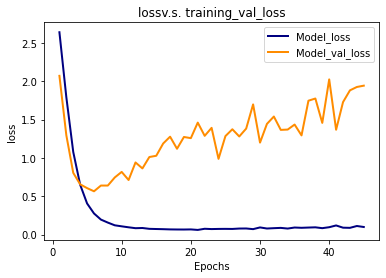

sparse_categorical_accuracy val_sparse_categorical_accuracy


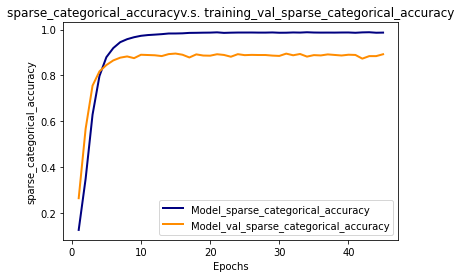

classification_report:
f1:  {'micro avg': 0.7613709573508568, 'macro avg': 0.7464313526213059} 

                          precision  recall  f1-score  support
alt.atheism                   0.768   0.633     0.694    319.0
comp.graphics                 0.596   0.710     0.648    389.0
comp.os.ms-windows.misc       0.764   0.574     0.655    394.0
comp.sys.ibm.pc.hardware      0.682   0.645     0.663    392.0
comp.sys.mac.hardware         0.701   0.797     0.746    385.0
comp.windows.x                0.884   0.711     0.788    395.0
misc.forsale                  0.854   0.777     0.813    390.0
rec.autos                     0.708   0.858     0.776    395.0
rec.motorcycles               0.783   0.889     0.833    398.0
rec.sport.baseball            0.810   0.879     0.843    397.0
rec.sport.hockey              0.956   0.845     0.897    827.0
sci.crypt                     0.875   0.934     0.904    396.0
sci.electronics               0.667   0.611     0.637    393.0
sci.med              

,precision,recall,f1-score,support
alt.atheism,0.768061,0.633229,0.694158,319.0
comp.graphics,0.596112,0.709512,0.647887,389.0
comp.os.ms-windows.misc,0.763514,0.573604,0.655072,394.0
comp.sys.ibm.pc.hardware,0.681941,0.645408,0.663172,392.0
comp.sys.mac.hardware,0.700913,0.797403,0.746051,385.0
comp.windows.x,0.883648,0.711392,0.788219,395.0
misc.forsale,0.853521,0.776923,0.813423,390.0
rec.autos,0.707724,0.858228,0.775744,395.0
rec.motorcycles,0.783186,0.889447,0.832941,398.0
rec.sport.baseball,0.809745,0.879093,0.842995,397.0


In [26]:
#### classification Report
history_plot(history)
y_pred = model.predict(X_test)
evaluation_report(test_label, np.argmax(y_pred, axis=1), labels=labels)

classification_report:
f1:  {'micro avg': 0.7613709573508568, 'macro avg': 0.7464313526213059} 

                          precision  recall  f1-score  support
alt.atheism                   0.768   0.633     0.694    319.0
comp.graphics                 0.596   0.710     0.648    389.0
comp.os.ms-windows.misc       0.764   0.574     0.655    394.0
comp.sys.ibm.pc.hardware      0.682   0.645     0.663    392.0
comp.sys.mac.hardware         0.701   0.797     0.746    385.0
comp.windows.x                0.884   0.711     0.788    395.0
misc.forsale                  0.854   0.777     0.813    390.0
rec.autos                     0.708   0.858     0.776    395.0
rec.motorcycles               0.783   0.889     0.833    398.0
rec.sport.baseball            0.810   0.879     0.843    397.0
rec.sport.hockey              0.956   0.845     0.897    827.0
sci.crypt                     0.875   0.934     0.904    396.0
sci.electronics               0.667   0.611     0.637    393.0
sci.med              

,precision,recall,f1-score,support
alt.atheism,0.768061,0.633229,0.694158,319.0
comp.graphics,0.596112,0.709512,0.647887,389.0
comp.os.ms-windows.misc,0.763514,0.573604,0.655072,394.0
comp.sys.ibm.pc.hardware,0.681941,0.645408,0.663172,392.0
comp.sys.mac.hardware,0.700913,0.797403,0.746051,385.0
comp.windows.x,0.883648,0.711392,0.788219,395.0
misc.forsale,0.853521,0.776923,0.813423,390.0
rec.autos,0.707724,0.858228,0.775744,395.0
rec.motorcycles,0.783186,0.889447,0.832941,398.0
rec.sport.baseball,0.809745,0.879093,0.842995,397.0


# LSTM

In [ ]:
# from tensorflow.keras.layers import SpatialDropout1D, GlobalMaxPooling1D, GlobalMaxPooling2D

# def model_Create(FS, NF, EMB, MDL, MNW, PWV = None, optimizer='RMSprop', trainable_switch=True):
#     model = Sequential()
#     model.add(Embedding(input_dim=MNW, output_dim=EMB, embeddings_initializer='uniform', mask_zero=True, input_length=MDL))
#     model.add(Flatten())   
# #     model.add(GlobalMaxPooling2D()) # downsampling
# #     model.add(SpatialDropout1D(0.2))    
#     model.add(Dense(1024, activation='relu'))   
#     model.add(Dense(512, activation='relu'))   
#     model.add(Dense(128, activation='relu'))   
#     model.add(Dense(64, activation='relu'))   
#     # model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
#     model.add(Dense(20, activation='softmax'))   
#     model.compile(optimizer=optimizer,
#           loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
#           metrics=[keras.metrics.SparseCategoricalAccuracy()])
#     return model

# model = model_Create(FS=FILTER_SIZES, NF=NUM_FILTERS, EMB=EMBEDDING_DIM,
#                      MDL=MAX_DOC_LEN, MNW=MAX_NB_WORDS+1, PWV=PWV, trainable_switch=trainable_switch)

In [ ]:
# visual_textCNN(model)

In [ ]:
# EMBEDDING_DIM = 200
# # W2V =  processor.w2v_pretrain(EMBEDDING_DIM, min_count=2, seed=1, cbow_mean=1,negative=5, window=20, workers=7) # pretrain w2v by gensim
# # W2V = processor.load_glove_w2v(EMBEDDING_DIM) # download glove
# trainable_switch = True
# W2V = None

In [ ]:
# BATCH_SIZE = 64
# NUM_EPOCHES = 10  # patience=20
# patience = 30

# BestModel_Name = 'text_CNN.h5'
# BEST_MODEL_FILEPATH = BestModel_Name

# earlyStopping = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=patience, verbose=1, mode='max') # patience: number of epochs with no improvement on monitor : val_loss
# checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
# history = model.fit(X_train, y_train, validation_split=0.2, batch_size=BATCH_SIZE, epochs=NUM_EPOCHES, callbacks=[earlyStopping, checkpoint], verbose=1)
# model.load_weights(BestModel_Name)

In [ ]:
# #### classification Report
# history_plot(history)
# y_pred = model.predict(X_test)
# # print(classification_report(y_test, np.argmax(y_pred, axis=1)))
# print(classification_report(test_label, np.argmax(y_pred, axis=1), target_names=labels))
# scores = model.evaluate(X_test, y_test, verbose=2)
# print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
# print( "\n\n\n")